<a href="https://colab.research.google.com/github/Schreiner-F/Sistemas-de-Control-2-2025/blob/main/1.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install control
!pip install xlrd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 22.9 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from control import tf, step_response
import math

In [14]:
# Cargar datos desde Excel
from google.colab import drive
drive.mount('/content/drive')
archivo = '/content/drive/MyDrive/FACULTAD /Sistemas de control 2 - Python/Curvas_Medidas_RLC_2025.xls'
hoja = 'Hoja1'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# Leer todo el archivo como tabla
df = pd.read_excel(archivo, sheet_name=hoja)
print(df.iloc[99:101])

           0  0.1  0.2  0.3  0.4
99   0.00100  0.0  0.0    0  0.0
100  0.00101  0.0  0.0    0  0.0


In [17]:
# Leer los datos
t0 = pd.read_excel(archivo, sheet_name=hoja, usecols="A", skiprows=999, nrows=19999).squeeze().to_numpy() - 0.01
i = pd.read_excel(archivo, sheet_name=hoja, usecols="B", skiprows=999, nrows=19999).squeeze().to_numpy()
Vc = pd.read_excel(archivo, sheet_name=hoja, usecols="C", skiprows=999, nrows=19999).squeeze().to_numpy()


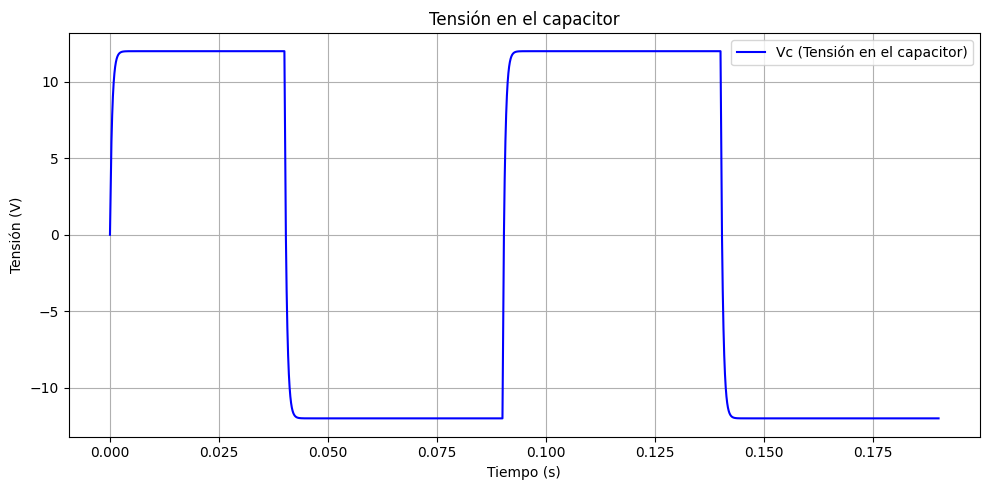

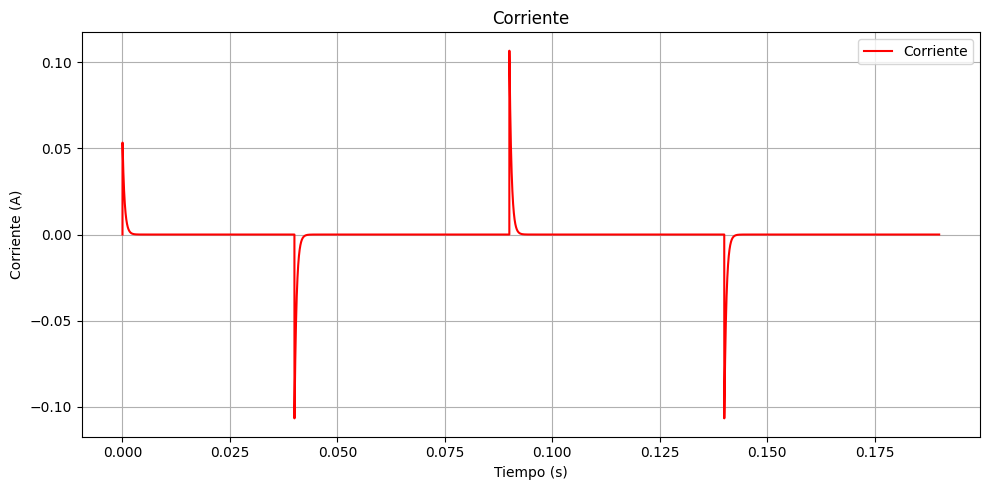

In [18]:
# Gráfico para la tensión en el capacitor
plt.figure(figsize=(10, 5))
plt.plot(t0, Vc, label="Vc (Tensión en el capacitor)", color='b')
plt.xlabel("Tiempo (s)")
plt.ylabel("Tensión (V)")
plt.title("Tensión en el capacitor")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Gráfico para la corriente
plt.figure(figsize=(10, 5))
plt.plot(t0, i, label="Corriente", color='r')
plt.xlabel("Tiempo (s)")
plt.ylabel("Corriente (A)")
plt.title("Corriente")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
# Configurar entrada escalón
StepAmplitude = 12

t0 = t0[:4000]
i = i[:4000]
Vc = Vc[:4000]

t_inic = t0[80]

In [20]:
# Encontrar valores necesarios para el método de Chema
def find_nearest_index(array, value):
    return np.argmin(np.abs(array - value))

idx_t1 = find_nearest_index(t0, t_inic)
idx_2t1 = find_nearest_index(t0, 2 * t_inic)
idx_3t1 = find_nearest_index(t0, 3 * t_inic)

y_t1 = Vc[idx_t1]
t_t1 = t0[idx_t1]
y_2t1 = Vc[idx_2t1]
t_2t1 = t0[idx_2t1]
y_3t1 = Vc[idx_3t1]
t_3t1 = t0[idx_3t1]

print(y_t1,y_2t1,y_3t1)

9.709527735954012 11.564883823955267 11.917341899472992


In [21]:
# Constante de ganancia
K = Vc[-1] / StepAmplitude

k1 = (1 / StepAmplitude) * y_t1 / K - 1
k2 = (1 / StepAmplitude) * y_2t1 / K - 1
k3 = (1 / StepAmplitude) * y_3t1 / K - 1

# Discriminante
be = 4 * k1**3 * k3 - 3 * k1**2 * k2**2 - 4 * k2**3 + k3**2 + 6 * k1 * k2 * k3

alfa1 = (k1 * k2 + k3 - np.sqrt(be)) / (2 * (k1**2 + k2))
alfa2 = (k1 * k2 + k3 + np.sqrt(be)) / (2 * (k1**2 + k2))

beta = (k1 + alfa2) / (alfa1 - alfa2)

T1_ang = -t_t1 / np.log(alfa1)
T2_ang = -t_t1 / np.log(alfa2)
T3_ang = beta * (T1_ang - T2_ang) + T1_ang

# Crear función de transferencia angular
num = K * np.array([T3_ang, 1])
den = np.convolve([T1_ang, 1], [T2_ang, 1])
sys_G_ang = tf(num, den)

# Planteamos un R arbitrario
R = 80

# Extraemos coeficientes
num_tf = np.squeeze(sys_G_ang.num)
den_tf = np.squeeze(sys_G_ang.den)
den_tf = den_tf / den_tf[0]  # Normalizar



In [22]:
# Cálculo de L y C
L = R / den_tf[1]
C = 1 / (L * den_tf[2])

# Normalizamos numerador y adaptamos a forma estándar RLC
num_tf = num_tf / num_tf[-1]
num_tf[-1] = num_tf[-1] * (1 / (L * C))
G = tf(num_tf, [1, R/L, 1/(L*C)])

# Simulación de ambas respuestas al escalón
t_sim = np.linspace(0, t0[-1], 1000)
t1, y1 = step_response(sys_G_ang, t_sim)
t2, y2 = step_response(G, t_sim)


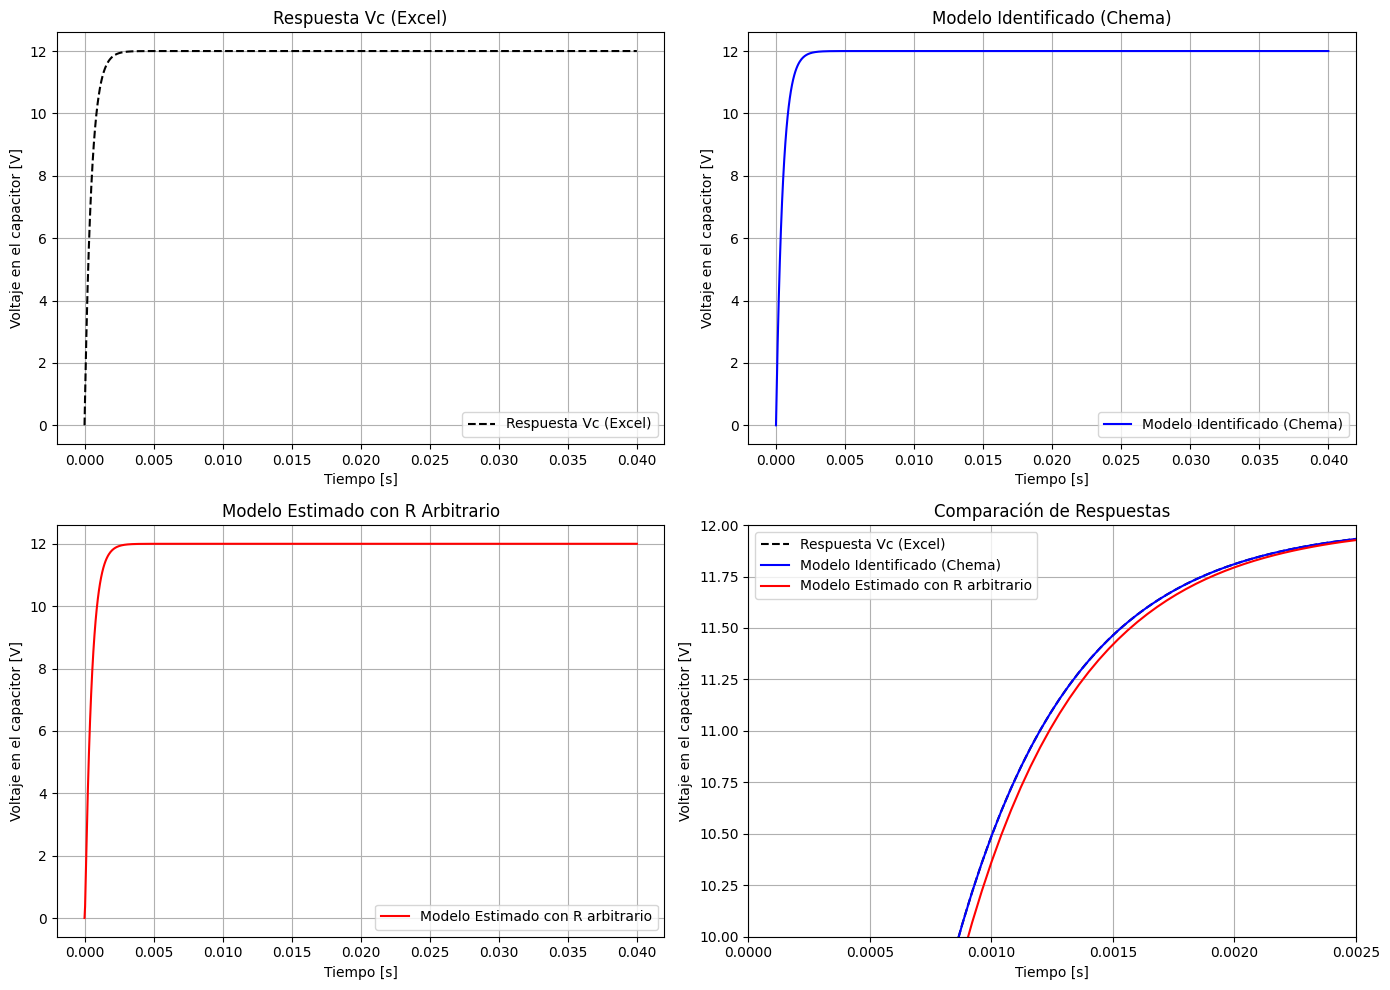

In [23]:
# Gráficas
import matplotlib.pyplot as plt

# Crear figura
plt.figure(figsize=(14, 10))

# Subgráfico 1: Respuesta Vc (Excel)
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer subgráfico
plt.plot(t0, Vc, 'k--', label='Respuesta Vc (Excel)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Voltaje en el capacitor [V]')
plt.title('Respuesta Vc (Excel)')
plt.legend()
plt.grid(True)

# Subgráfico 2: Modelo Identificado (Chema)
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo subgráfico
plt.plot(t1, y1 * StepAmplitude, 'b', label='Modelo Identificado (Chema)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Voltaje en el capacitor [V]')
plt.title('Modelo Identificado (Chema)')
plt.legend()
plt.grid(True)

# Subgráfico 3: Modelo Estimado con R Arbitrario
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer subgráfico
plt.plot(t2, y2 * StepAmplitude, 'r', label='Modelo Estimado con R arbitrario')
plt.xlabel('Tiempo [s]')
plt.ylabel('Voltaje en el capacitor [V]')
plt.title('Modelo Estimado con R Arbitrario')
plt.legend()
plt.grid(True)

# Subgráfico 4: Comparación de los 3 modelos
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto subgráfico
plt.xlim(0, 0.0025)   # Zoom en el tiempo (0 a 0.0025 s)
plt.ylim(10, 12)      # Zoom en el voltaje (10 a 12 V)
plt.plot(t0, Vc, 'k--', label='Respuesta Vc (Excel)')
plt.plot(t1, y1 * StepAmplitude, 'b', label='Modelo Identificado (Chema)')
plt.plot(t2, y2 * StepAmplitude, 'r', label='Modelo Estimado con R arbitrario')
plt.xlabel('Tiempo [s]')
plt.ylabel('Voltaje en el capacitor [V]')
plt.title('Comparación de Respuestas')
plt.legend()
plt.grid(True)

# Ajustar el layout para que no se superpongan los subgráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()



In [26]:
import numpy as np
import control as ctrl

# Asegurémonos de que los coeficientes sean arrays unidimensionales
num_G = np.squeeze(G.num)  # Numerador de G
den_G = np.squeeze(G.den)  # Denominador de G

# Ahora puedes calcular los polos de G
poles_G = np.roots(den_G)
print("Polos de G:", poles_G)

# Asegurémonos de que el denominador y numerador estén normalizados
num_tf = num_tf / np.max(np.abs(num_tf))  # Normalizar el numerador
den_tf = den_tf / np.max(np.abs(den_tf))  # Normalizar el denominador

# Crear la función de transferencia normalizada
sys_G_ang = ctrl.TransferFunction(num_tf, den_tf)

# Ahora calcula los polos de la función de transferencia
poles_sys_G_ang = ctrl.pole(sys_G_ang)
print("Polos de sys_G_ang:", poles_sys_G_ang)


In [26]:
# Imprimir resultados
print(f"Ganancia K: {K:.4f}")
print(f"T1: {T1_ang:.6f} s, T2: {T2_ang:.6f} s, T3: {T3_ang:.6f} s")
print(f"Parámetros estimados -> R: {R} Ω, L: {L:.6e} H, C: {C:.6e} F")